This is used to evalutae the top structures predicted by the embedding model trained with structures reported in the past. 

In [1]:
import pandas as pd
import numpy as np
import random
from gensim.models.doc2vec import Doc2Vec
from mofgraph2vec.featurize.mof2doc import MOF2doc
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
from scipy.stats import spearmanr

import matplotlib as mpl
mpl.rcParams["font.size"] = 18

/Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/lib/python3.8/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/lib/python3.8/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/l

Model path with more KPIs embedded:
- 2005: offline-run-20230619_160933-0qrbdkho (0.52086)
- 2006: offline-run-20230619_161055-d5fvvhz0 (0.539)
- 2007: offline-run-20230619_161333-5zneohcw (0.39101)
- 2008: offline-run-20230619_161517-v615p1sy (0.47242)
- 2009: offline-run-20230619_161722-azimlp7w (0.59879)
- 2010: offline-run-20230619_161912-6ru00ap8 (0.47331)
- 2011: offline-run-20230619_162119-0m7vvgrm (0.31828)
- 2012: offline-run-20230619_162318-wrj5ustj (0.45608)
- 2013: offline-run-20230619_162516-999ajj5e (0.26985)
- 2014: offline-run-20230619_162720-bx7vvkn6 (0.37008)
- 2015: offline-run-20230619_162921-a03ypg0w (0.30663)

In [2]:
def cosine(a, b):
    cos = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos

Model path
- 2005: offline-run-20230612_090352-a0mbcfx8
- 2006: offline-run-20230612_090642-lhim71qf
- 2007: offline-run-20230612_090742-q749fd10
- 2008: offline-run-20230612_090833-vjoka8wq
- 2009: offline-run-20230612_090933-j60pg58w
- 2010: offline-run-20230612_091150-8s0v83os
- 2011: offline-run-20230612_105426-haffm3kn
- 2012: offline-run-20230612_112249-0mh9qy60
- 2013: offline-run-20230612_141243-q7he2jkk
- 2014: offline-run-20230612_145730-qqfs7t2j
- 2015: offline-run-20230612_155540-h3cqbnk8
- 2016: offline-run-20230612_165530-o07k0gw3
- 2017: offline-run-20230612_203209-8qutj4u3

In [2]:
df = pd.read_csv("../data/md-core.csv")#.set_index("info.name")

In [3]:
recom_target = "outputs.selectivity"

In [5]:
def bin_indexing(values, q, threshold):
    bin_values, bins = pd.qcut(values, q, labels=np.arange(len(q) - 1), retbins=True)
    thre_bin = np.digitize(threshold, bins) -1
    return thre_bin

In [4]:
test_corpus_config = {
  "embed_label": False,
  "label_path": "../../data/md-core.csv",
  "labels_to_embed": ["outputs.logKH_CO2", "outputs.logKH_CH4"],
  "id_column": "info.name",
  "wl_step": 2,
  "n_components": 2,
  "use_hash": False,
  "writing_style": "paragraph",
  "composition": False,
  "mode": "all",
  "embed_cif": False
}

In [5]:
def load_pretrained(model_path):
    model = Doc2Vec.load(model_path)
    co2_kh_vecs = [model.dv["outputs.logKH_CO2_%s" %i] for i in range(10)]
    ch4_kh_vecs = [model.dv["outputs.logKH_CH4_%s" %i] for i in range(10)]
    #co2_kh_vec = model.dv["outputs.logKH_CO2_high"]
    #ch4_kh_vec = model.dv["outputs.logKH_CH4_high"]
    return model, co2_kh_vecs, ch4_kh_vecs

In [6]:
def get_test_data(test_cif_path, model):
    test_corpus = {}
    test_ds = MOF2doc(cif_path=test_cif_path, **test_corpus_config).get_documents()
    for dp in test_ds:
        test_corpus.update(
            {
                dp.tags[0]: model.infer_vector(dp.words, epochs=300)
            }
        )
    return test_corpus

In [7]:
def get_similarities(test_corpus, bench_vec):
    test_cosine = {}
    for key, vec in test_corpus.items():
        test_cosine.update(
            {   
                key: [cosine(bench, vec) for bench in bench_vec]
            }
        )
    return test_cosine

In [8]:
def select_top_n(test_similarities, test_years, top_percent):
    topn = int(len(test_similarities)*top_percent)
    # recommendation from similarity
    similarities = np.array([np.array(sim).mean() for _, sim in test_similarities.items()])
    top_indices = similarities.argsort()[-topn:][::-1]
    recommendations = []
    for index in top_indices:
        recommendations.append((list(test_similarities)[index], similarities[index]))

    # topN from simulation
    names = df[df["info.year"].isin(test_years)]["info.name"].values
    #simulations = df[df["info.year"].isin(test_years)][recom_target].values
    simu_co2 = df[df["info.year"].isin(test_years)]["outputs.logKH_CO2"].values
    simu_ch4 = df[df["info.year"].isin(test_years)]["outputs.logKH_CH4"].values
    simulations = simu_co2 - simu_ch4
    top_simulation = simulations.argsort()[-topn:][::-1]
    true_top = []
    top_names = []
    for index in top_simulation:
        true_top.append((names[index], simulations[index]))
        top_names.append(names[index])
    
    # random selection 
    rand_acc_time = []
    time = 0
    while time < 5:
        random_names = random.choices(names, k=topn)
        true_or_false = [True if name in top_names else False for name in random_names]
        rand_acc_time.append(sum(true_or_false)/len(true_or_false))
        time += 1

    true_or_false = [True if name in top_names else False for name, sim in recommendations]
    recm_acc = sum(true_or_false)/len(true_or_false)

    rand_acc = np.mean(rand_acc_time)

    return recm_acc, rand_acc


In [11]:
topP = 0.3

In [96]:
df["outputs.selectivity"] = df['outputs.logKH_CO2'].values - df['outputs.logKH_CH4'].values

In [48]:
def cal_spearman(test_cosines):
    test_sim = {name: np.mean(x) for name, x in test_cosines.items()}
    model_v = [sim for i, sim in test_sim.items()]
    simul_v = [df.loc[i, "outputs.selectivity"] for i, sim in test_sim.items()]

    return spearmanr(model_v, simul_v)[0]

In [46]:
model_path = "../experiments/workflow/wandb/offline-run-20230619_160933-0qrbdkho/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
"""
bench_vecs = [
    co2_kh_vecs[-1] + ch4_kh_vecs[0],
    co2_kh_vecs[-1] + ch4_kh_vecs[1],
    co2_kh_vecs[-1] + ch4_kh_vecs[2],
    co2_kh_vecs[-2] + ch4_kh_vecs[0],
    co2_kh_vecs[-2] + ch4_kh_vecs[1],
    co2_kh_vecs[-2] + ch4_kh_vecs[2],
    co2_kh_vecs[-3] + ch4_kh_vecs[0],
    co2_kh_vecs[-3] + ch4_kh_vecs[1],
    co2_kh_vecs[-4] + ch4_kh_vecs[2],
]
"""
bench_vecs = [co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]


percent_2005 = []
for test_years in [
    [2006], [2006, 2007], 
    [2006, 2007, 2008], [2006, 2007, 2008, 2009], 
    [2006, 2007, 2008, 2009, 2010], 
    [2006, 2007, 2008, 2009, 2010, 2011], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    model_acc, rand_acc = select_top_n(test_cosines, test_years, topP)
    percent_2005.append((model_acc, rand_acc))


100%|██████████| 1837/1837 [00:05<00:00, 352.09it/s]


In [48]:
# cutoff 2006
model_path = "../experiments/workflow/wandb/offline-run-20230619_161055-d5fvvhz0/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
"""
bench_vecs = [
    co2_kh_vecs[-1] + ch4_kh_vecs[0],
    co2_kh_vecs[-1] + ch4_kh_vecs[1],
    co2_kh_vecs[-1] + ch4_kh_vecs[2],
    co2_kh_vecs[-2] + ch4_kh_vecs[0],
    co2_kh_vecs[-2] + ch4_kh_vecs[1],
    co2_kh_vecs[-2] + ch4_kh_vecs[2],
    co2_kh_vecs[-3] + ch4_kh_vecs[0],
    co2_kh_vecs[-3] + ch4_kh_vecs[1],
    co2_kh_vecs[-4] + ch4_kh_vecs[2],
]
"""
bench_vecs = [co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]

percent_2006 = []
for test_years in [
    [2007], 
    [2007, 2008], [2007, 2008, 2009], 
    [2007, 2008, 2009, 2010], 
    [2007, 2008, 2009, 2010, 2011], 
    [2007, 2008, 2009, 2010, 2011, 2012], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)

    model_acc, rand_acc = select_top_n(test_cosines, test_years, topP)
    percent_2006.append((model_acc, rand_acc))

100%|██████████| 1775/1775 [00:05<00:00, 339.60it/s]


In [49]:
# cutoff 2007
model_path = "../experiments/workflow/wandb/offline-run-20230619_161333-5zneohcw/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)

bench_vecs = [co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
"""
bench_vecs = [
    co2_kh_vecs[-1] + ch4_kh_vecs[0],
    co2_kh_vecs[-1] + ch4_kh_vecs[1],
    co2_kh_vecs[-1] + ch4_kh_vecs[2],
    co2_kh_vecs[-2] + ch4_kh_vecs[0],
    co2_kh_vecs[-2] + ch4_kh_vecs[1],
    co2_kh_vecs[-2] + ch4_kh_vecs[2],
    co2_kh_vecs[-3] + ch4_kh_vecs[0],
    co2_kh_vecs[-3] + ch4_kh_vecs[1],
    co2_kh_vecs[-4] + ch4_kh_vecs[2],
]
"""

percent_2007 = []
for test_years in [
    [2008], 
    [2008, 2009], [2008, 2009, 2010], 
    [2008, 2009, 2010, 2011], 
    [2008, 2009, 2010, 2011, 2012], 
    [2008, 2009, 2010, 2011, 2012, 2013], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    
    model_acc, rand_acc = select_top_n(test_cosines, test_years, topP)
    percent_2007.append((model_acc, rand_acc))

100%|██████████| 1699/1699 [00:05<00:00, 332.41it/s]


In [50]:
# cutoff 2008 offline-run-20230612_090833-vjoka8wq
model_path = "../experiments/workflow/wandb/offline-run-20230619_161517-v615p1sy/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)

bench_vecs = [co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
"""
bench_vecs = [
    co2_kh_vecs[-1] + ch4_kh_vecs[0],
    co2_kh_vecs[-1] + ch4_kh_vecs[1],
    co2_kh_vecs[-1] + ch4_kh_vecs[2],
    co2_kh_vecs[-2] + ch4_kh_vecs[0],
    co2_kh_vecs[-2] + ch4_kh_vecs[1],
    co2_kh_vecs[-2] + ch4_kh_vecs[2],
    co2_kh_vecs[-3] + ch4_kh_vecs[0],
    co2_kh_vecs[-3] + ch4_kh_vecs[1],
    co2_kh_vecs[-4] + ch4_kh_vecs[2],
]
"""

percent_2008 = []
for test_years in [
    [2009], 
    [2009, 2010], [2009, 2010, 2011], 
    [2009, 2010, 2011, 2012], 
    [2009, 2010, 2011, 2012, 2013], 
    [2009, 2010, 2011, 2012, 2013, 2014], 
    [2009, 2010, 2011, 2012, 2013, 2014, 2015], 
    [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    
    model_acc, rand_acc = select_top_n(test_cosines, test_years, topP)
    percent_2008.append((model_acc, rand_acc))

  0%|          | 0/99 [00:00<?, ?it/s]

100%|██████████| 1614/1614 [00:04<00:00, 359.31it/s]


In [51]:
# cutoff 2009
model_path = "../experiments/workflow/wandb/offline-run-20230619_161722-azimlp7w/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)

bench_vecs = [co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
"""
bench_vecs = [
    co2_kh_vecs[-1] + ch4_kh_vecs[0],
    co2_kh_vecs[-1] + ch4_kh_vecs[1],
    co2_kh_vecs[-1] + ch4_kh_vecs[2],
    co2_kh_vecs[-2] + ch4_kh_vecs[0],
    co2_kh_vecs[-2] + ch4_kh_vecs[1],
    co2_kh_vecs[-2] + ch4_kh_vecs[2],
    co2_kh_vecs[-3] + ch4_kh_vecs[0],
    co2_kh_vecs[-3] + ch4_kh_vecs[1],
    co2_kh_vecs[-4] + ch4_kh_vecs[2],
]
"""

percent_2009 = []
for test_years in [
    [2010], 
    [2010, 2011], [2010, 2011, 2012], 
    [2010, 2011, 2012, 2013], 
    [2010, 2011, 2012, 2013, 2014], 
    [2010, 2011, 2012, 2013, 2014, 2015], 
    [2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)

    model_acc, rand_acc = select_top_n(test_cosines, test_years, topP)
    percent_2009.append((model_acc, rand_acc))

100%|██████████| 1515/1515 [00:04<00:00, 356.86it/s]


In [52]:
# cutoff 2010
model_path = "../experiments/workflow/wandb/offline-run-20230619_161912-6ru00ap8/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)

bench_vecs = [co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
"""
bench_vecs = [
    co2_kh_vecs[-1] + ch4_kh_vecs[0],
    co2_kh_vecs[-1] + ch4_kh_vecs[1],
    co2_kh_vecs[-1] + ch4_kh_vecs[2],
    co2_kh_vecs[-2] + ch4_kh_vecs[0],
    co2_kh_vecs[-2] + ch4_kh_vecs[1],
    co2_kh_vecs[-2] + ch4_kh_vecs[2],
    co2_kh_vecs[-3] + ch4_kh_vecs[0],
    co2_kh_vecs[-3] + ch4_kh_vecs[1],
    co2_kh_vecs[-4] + ch4_kh_vecs[2],
]
"""

percent_2010 = []
for test_years in [
    [2011], 
    [2011, 2012], [2011, 2012, 2013], 
    [2011, 2012, 2013, 2014], 
    [2011, 2012, 2013, 2014, 2015], 
    [2011, 2012, 2013, 2014, 2015, 2016], 
    [2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)

    model_acc, rand_acc = select_top_n(test_cosines, test_years, topP)
    percent_2010.append((model_acc, rand_acc))

100%|██████████| 1385/1385 [00:04<00:00, 281.27it/s]


In [53]:
# cutoff 2011
model_path = "../experiments/workflow/wandb/offline-run-20230619_162119-0m7vvgrm/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)

bench_vecs = [co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
"""
bench_vecs = [
    co2_kh_vecs[-1] + ch4_kh_vecs[0],
    co2_kh_vecs[-1] + ch4_kh_vecs[1],
    co2_kh_vecs[-1] + ch4_kh_vecs[2],
    co2_kh_vecs[-2] + ch4_kh_vecs[0],
    co2_kh_vecs[-2] + ch4_kh_vecs[1],
    co2_kh_vecs[-2] + ch4_kh_vecs[2],
    co2_kh_vecs[-3] + ch4_kh_vecs[0],
    co2_kh_vecs[-3] + ch4_kh_vecs[1],
    co2_kh_vecs[-4] + ch4_kh_vecs[2],
]
"""

percent_2011 = []
for test_years in [
    [2012], 
    [2012, 2013], 
    [2012, 2013, 2014], 
    [2012, 2013, 2014, 2015], 
    [2012, 2013, 2014, 2015, 2016], 
    [2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)

    model_acc, rand_acc = select_top_n(test_cosines, test_years, topP)
    percent_2011.append((model_acc, rand_acc))

100%|██████████| 1207/1207 [00:03<00:00, 341.31it/s]


In [54]:
# cutoff 2012
model_path = "../experiments/workflow/wandb/offline-run-20230619_162318-wrj5ustj/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)

bench_vecs = [co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
"""
bench_vecs = [
    co2_kh_vecs[-1] + ch4_kh_vecs[0],
    co2_kh_vecs[-1] + ch4_kh_vecs[1],
    co2_kh_vecs[-1] + ch4_kh_vecs[2],
    co2_kh_vecs[-2] + ch4_kh_vecs[0],
    co2_kh_vecs[-2] + ch4_kh_vecs[1],
    co2_kh_vecs[-2] + ch4_kh_vecs[2],
    co2_kh_vecs[-3] + ch4_kh_vecs[0],
    co2_kh_vecs[-3] + ch4_kh_vecs[1],
    co2_kh_vecs[-4] + ch4_kh_vecs[2],
]
"""

percent_2012 = []
for test_years in [
    [2013], 
    [2013, 2014], 
    [2013, 2014, 2015], 
    [2013, 2014, 2015, 2016], 
    [2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)

    model_acc, rand_acc = select_top_n(test_cosines, test_years, topP)
    percent_2012.append((model_acc, rand_acc))

100%|██████████| 999/999 [00:03<00:00, 256.04it/s]


In [55]:
# cutoff 2013
model_path = "../experiments/workflow/wandb/offline-run-20230619_162516-999ajj5e/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)

bench_vecs = [co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
"""
bench_vecs = [
    co2_kh_vecs[-1] + ch4_kh_vecs[0],
    co2_kh_vecs[-1] + ch4_kh_vecs[1],
    co2_kh_vecs[-1] + ch4_kh_vecs[2],
    co2_kh_vecs[-2] + ch4_kh_vecs[0],
    co2_kh_vecs[-2] + ch4_kh_vecs[1],
    co2_kh_vecs[-2] + ch4_kh_vecs[2],
    co2_kh_vecs[-3] + ch4_kh_vecs[0],
    co2_kh_vecs[-3] + ch4_kh_vecs[1],
    co2_kh_vecs[-4] + ch4_kh_vecs[2],
]
"""

percent_2013 = []
for test_years in [
    [2014], 
    [2014, 2015], 
    [2014, 2015, 2016], 
    [2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)

    model_acc, rand_acc = select_top_n(test_cosines, test_years, topP)
    percent_2013.append((model_acc, rand_acc))

  0%|          | 0/212 [00:00<?, ?it/s]

100%|██████████| 773/773 [00:02<00:00, 331.38it/s]


In [56]:
# cutoff 2014
model_path = "../experiments/workflow/wandb/offline-run-20230619_162720-bx7vvkn6/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)

bench_vecs = [co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
"""
bench_vecs = [
    co2_kh_vecs[-1] + ch4_kh_vecs[0],
    co2_kh_vecs[-1] + ch4_kh_vecs[1],
    co2_kh_vecs[-1] + ch4_kh_vecs[2],
    co2_kh_vecs[-2] + ch4_kh_vecs[0],
    co2_kh_vecs[-2] + ch4_kh_vecs[1],
    co2_kh_vecs[-2] + ch4_kh_vecs[2],
    co2_kh_vecs[-3] + ch4_kh_vecs[0],
    co2_kh_vecs[-3] + ch4_kh_vecs[1],
    co2_kh_vecs[-4] + ch4_kh_vecs[2],
]
"""

percent_2014 = []
for test_years in [
    [2015], 
    [2015, 2016], 
    [2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)

    model_acc, rand_acc = select_top_n(test_cosines, test_years, topP)
    percent_2014.append((model_acc, rand_acc))

100%|██████████| 561/561 [00:01<00:00, 292.62it/s]


In [105]:
# cutoff 2015
model_path = "../experiments/workflow/wandb/offline-run-20230612_155540-h3cqbnk8/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)

#bench_vecs = [co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]

bench_vecs = [
    co2_kh_vecs[-1] - ch4_kh_vecs[-1],
    co2_kh_vecs[-1] - ch4_kh_vecs[-2],
    #co2_kh_vecs[-1] - ch4_kh_vecs[-3],
    co2_kh_vecs[-2] - ch4_kh_vecs[-1],
    co2_kh_vecs[-2] - ch4_kh_vecs[-2],
    #co2_kh_vecs[-2] - ch4_kh_vecs[-3],
    co2_kh_vecs[-3] - ch4_kh_vecs[-1],
    co2_kh_vecs[-3] - ch4_kh_vecs[-2],
    #co2_kh_vecs[-4] - ch4_kh_vecs[-3],
]


percent_2015 = []
for test_years in [
    [2016], 
    [2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)

    model_acc, rand_acc = select_top_n(test_cosines, test_years, topP)
    percent_2015.append((model_acc, rand_acc))

100%|██████████| 320/320 [00:01<00:00, 165.98it/s]


In [106]:
percent_2015

[(0.6363636363636364, 0.2818181818181818), (0.625, 0.3229166666666667)]

In [61]:
rand_avg = []

for index in range(len(percent_2005)):
    a = 0
    count = 0
    for var in [percent_2005,
        percent_2006,
        percent_2007,
        percent_2008,
        percent_2009,
        percent_2010,
        percent_2011,
        percent_2012,
        percent_2013,
        percent_2014,
        percent_2015]:
        if index < len(var):
            a += var[index][1]
            count += 1
    rand_avg.append(a/count)


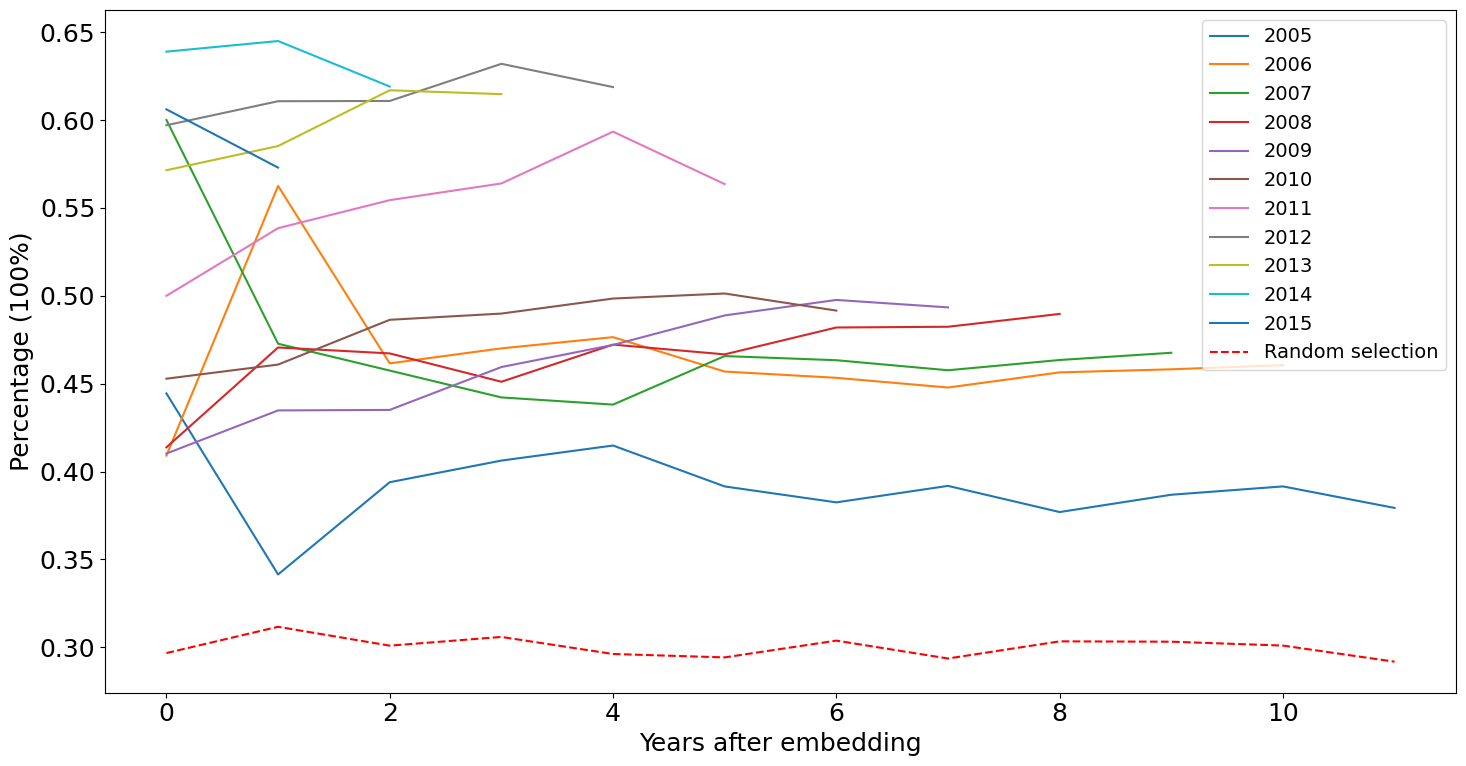

In [62]:
plt.figure(figsize=(15, 8))
plt.plot(range(len(percent_2005)), [p[0] for p in percent_2005], label="2005")
plt.plot(range(len(percent_2006)), [p[0] for p in percent_2006], label="2006")
plt.plot(range(len(percent_2007)), [p[0] for p in percent_2007], label="2007")
plt.plot(range(len(percent_2008)), [p[0] for p in percent_2008], label="2008")
plt.plot(range(len(percent_2009)), [p[0] for p in percent_2009], label="2009")
plt.plot(range(len(percent_2010)), [p[0] for p in percent_2010], label="2010")
plt.plot(range(len(percent_2011)), [p[0] for p in percent_2011], label="2011")
plt.plot(range(len(percent_2012)), [p[0] for p in percent_2012], label="2012")
plt.plot(range(len(percent_2013)), [p[0] for p in percent_2013], label="2013")
plt.plot(range(len(percent_2014)), [p[0] for p in percent_2014], label="2014")
plt.plot(range(len(percent_2015)), [p[0] for p in percent_2015], label="2015")

plt.plot(range(len(rand_avg)), rand_avg, "r--", label="Random selection")

plt.xlabel("Years after embedding")
plt.ylabel("Percentage (100%)")

plt.legend(fontsize=14)

plt.tight_layout()
#plt.savefig("../../../files/cutoff_co2-ch4_3by3bin.png")

In [26]:
time = 0
percent_bench_time = []
while time < 10:
    percent_bench = []
    for cutoff in [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014]:
        df_cutoff = df[df["info.year"]<(cutoff+1)]["outputs.logKH_CO2"]
        subdf = df_cutoff.sample(n=topN)
        subdf_thre = subdf[subdf>THRESHOLD]
        percent_bench.append(len(subdf_thre)/len(subdf))
    percent_bench_time.append(percent_bench)
    time += 1

percent_bench_avg = np.array(percent_bench_time).mean(axis=1)

NameError: name 'topN' is not defined

In [ ]:
co2_values = []
cutoff_years = [2006, 2008, 2010, 2012, 2014, 2016, 2018]
for year in cutoff_years:
     co2_values.append(df[df["info.year"]<(year+1)]["outputs.logKH_CO2"].values)

fig, ax = plt.subplots(figsize=(5,5))
ax.violinplot(co2_values,positions=range(len(cutoff_years)),vert=False,showmeans=True)

def set_axis_style(ax, labels):
    ax.get_yaxis().set_tick_params(direction='out')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_yticks(range(len(labels)))
    ax.set_yticklabels(labels)
    ax.set_ylim(0.25-1, len(labels) + 0.75 -1)
    ax.set_ylabel('Cutoff year')

set_axis_style(ax, cutoff_years)

In [14]:
model_path = "../experiments/workflow/wandb/offline-run-20230612_090352-a0mbcfx8/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)


percent_2005 = []

test_years = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]

test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
test_corpus =  get_test_data(test_cif_dir, model)
#test_cosines = get_similarities(test_corpus, bench_vecs)
#model_acc, rand_acc = select_top_n(test_cosines, test_years, topP)
#percent_2005.append((model_acc, rand_acc))

  0%|          | 0/1837 [00:00<?, ?it/s]

100%|██████████| 1837/1837 [00:05<00:00, 330.13it/s]


In [69]:
train_corpus = get_test_data(["../data/cifs/md_1990/", "../data/cifs/md_1990_2000/", "../data/cifs/md_2000_2005/"], model)

100%|██████████| 158/158 [00:00<00:00, 299.21it/s]


In [15]:
from sklearn.manifold import TSNE

In [75]:
to_tsne = [co2_kh_vecs[-1]]
"""
for i, arr in train_corpus.items():
    to_tsne.append(arr)
"""
for i, arr in test_corpus.items():
    to_tsne.append(arr)
    
to_tsne = np.array(to_tsne)

In [77]:
tsne_obj = TSNE(n_components=2, learning_rate=200, random_state=1717, n_jobs=6)
vec_from_tsne = tsne_obj.fit_transform(to_tsne)

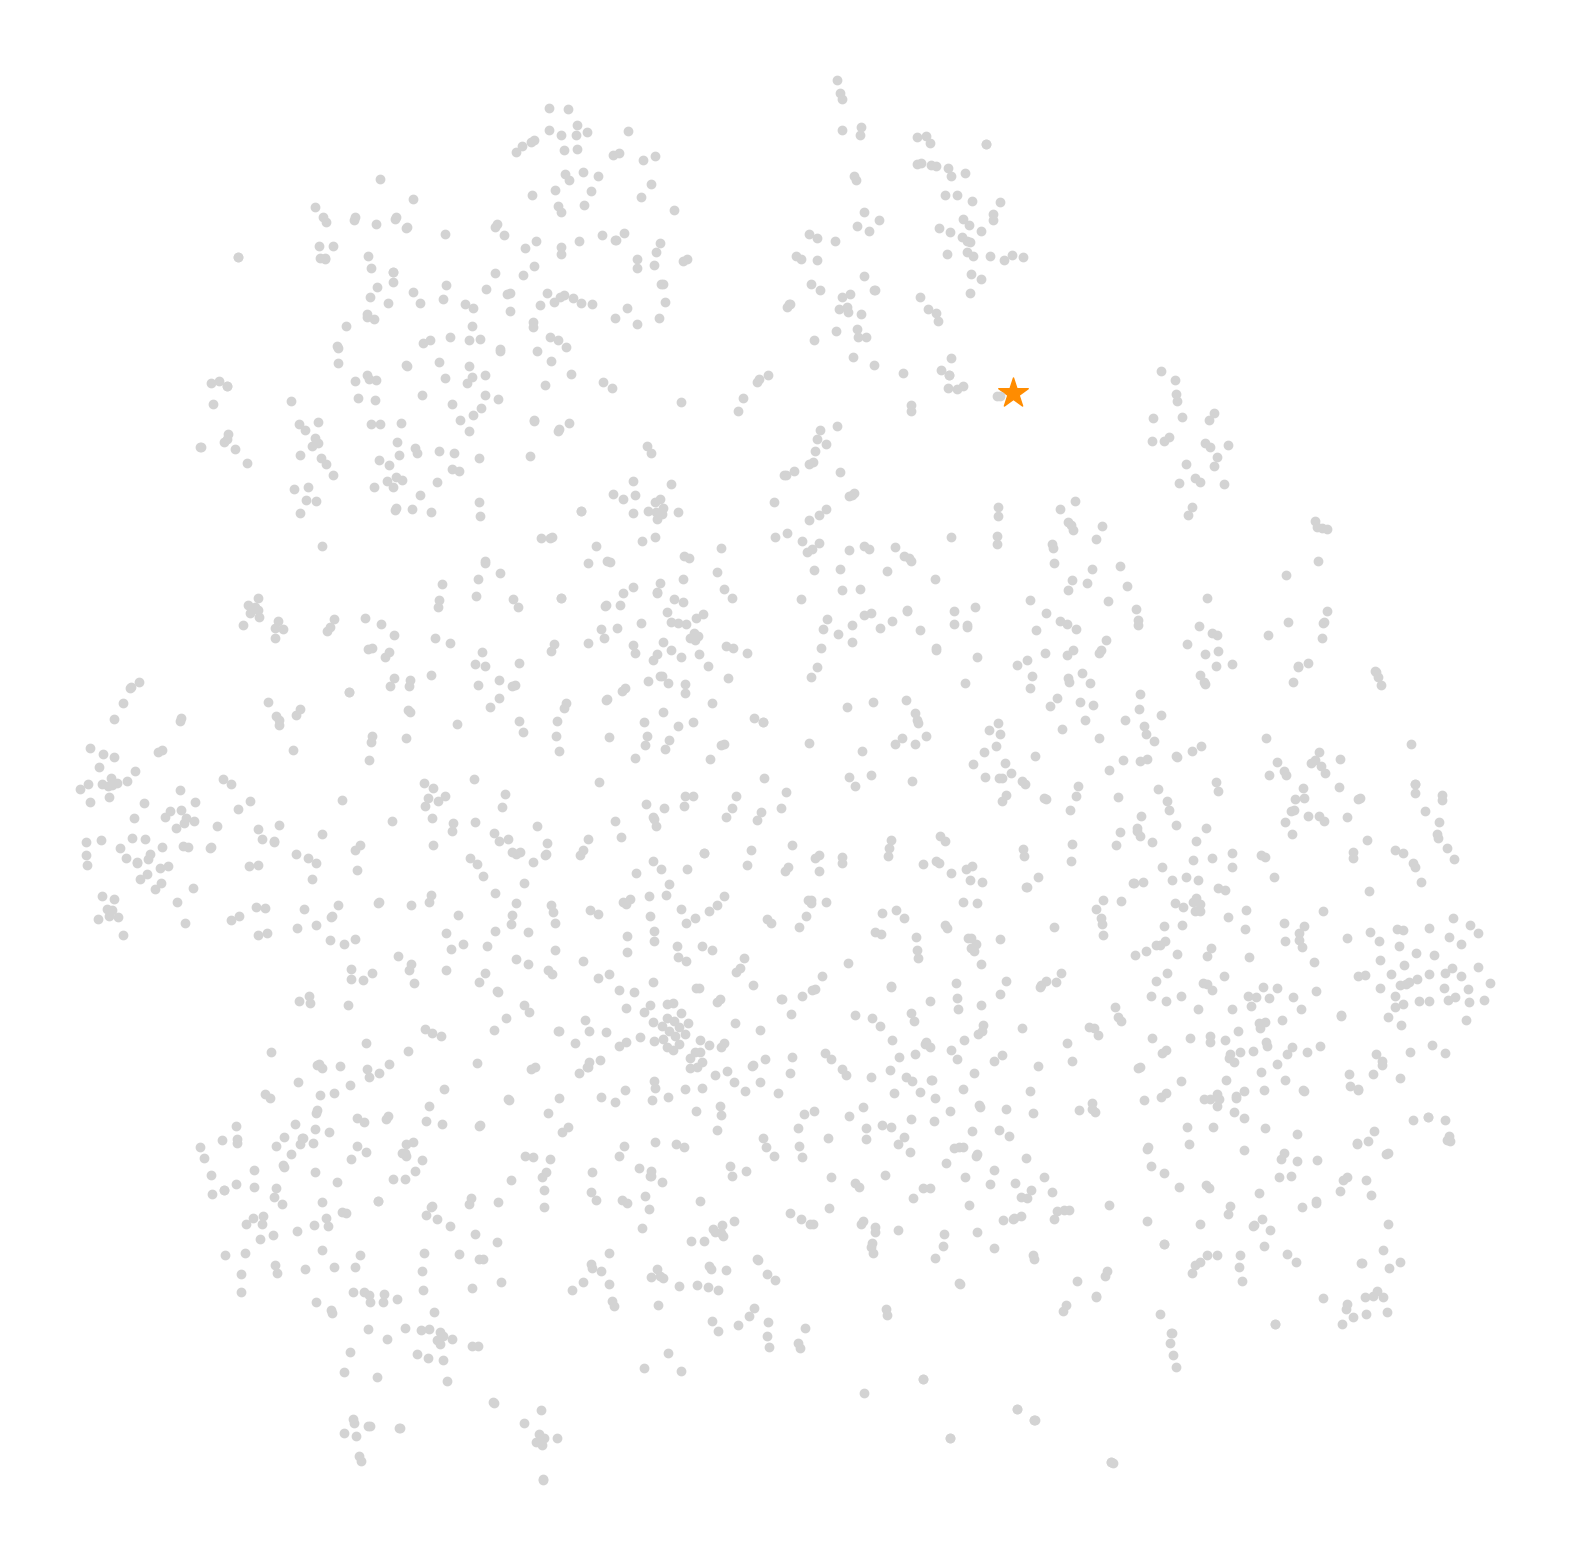

In [80]:
fig, ax = plt.subplots()
fig.set_size_inches(20,20)
fig.patch.set_visible(False)
ax.axis('off')

ax.scatter(vec_from_tsne[0,0], vec_from_tsne[0,1], marker="*", s=500, c="darkorange")
#ax.scatter(vec_from_tsne[1:1+len(train_corpus),0], vec_from_tsne[1:1+len(train_corpus),1], c="cadetblue")
ax.scatter(vec_from_tsne[1:,0], vec_from_tsne[1:,1], c='lightgray')

fig.savefig("../../../files/co2_test_2005_tsne.png", dpi=1200)

In [51]:
from collections import Counter

In [52]:
Counter(df["info.year"].values)

Counter({2015.0: 241,
         2014.0: 212,
         2016.0: 220,
         2010.0: 130,
         2001.0: 21,
         2012.0: 208,
         2013.0: 226,
         2011.0: 178,
         2006.0: 62,
         2000.0: 22,
         2005.0: 61,
         2008.0: 85,
         2017.0: 100,
         2009.0: 99,
         2007.0: 76,
         1997.0: 2,
         1993.0: 2,
         2004.0: 43,
         2003.0: 17,
         2002.0: 24,
         1999.0: 4,
         1985.0: 1,
         1998.0: 12,
         1995.0: 3,
         1980.0: 1,
         1989.0: 1,
         1991.0: 1,
         1996.0: 1,
         1994.0: 2,
         1992.0: 1})

In [172]:
years = df["info.year"].values

In [97]:
np.arange(1980, 2017)

array([1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990,
       1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001,
       2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012,
       2013, 2014, 2015, 2016])

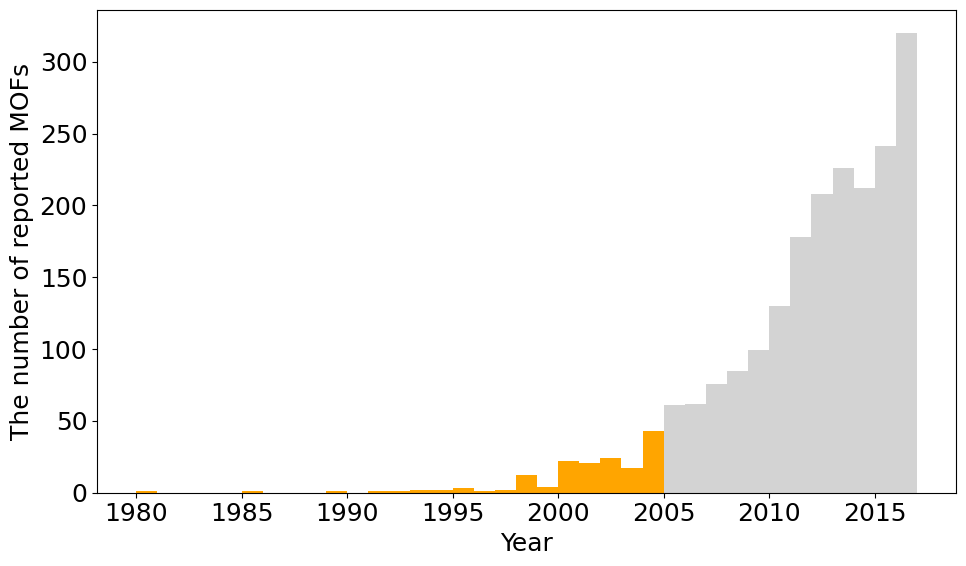

In [179]:
plt.figure(figsize=(10,6))
bins = np.arange(1980, 2018)
n, bins, patches = plt.hist(years, color='lightgray', bins=bins)

threshold = 2005
# Change the color of bins below the threshold to blue
for patch, bin_value in zip(patches, bins):
    if bin_value < threshold:
        patch.set_facecolor('orange')

plt.xlabel("Year")
plt.ylabel("The number of reported MOFs")
plt.tight_layout()
#plt.savefig("../../../files/final_v/2-distribution.png", dpi=1200)

In [100]:
v_co2 = co2_kh_vecs[-1]
v_ch4 = ch4_kh_vecs[0]
v_desire = v_co2 + v_ch4

In [102]:
V = np.array([v_co2, v_ch4, v_desire])

#projector = TSNE(n_components=2, learning_rate=200, random_state=1717, n_jobs=6)

#vectors_2d = tsne_obj.fit_transform(vectors)

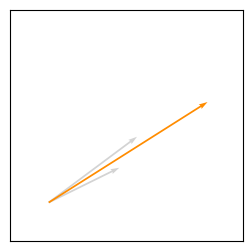

In [131]:
plt.figure(figsize=(3,3))
origin = np.array([[0, 0, 0],[0, 0, 0]])
plt.quiver(*origin, V[:,0], V[:,1], color=['lightgray','lightgray','darkorange'], scale=2.5)

plt.xlim([-0.01, 0.05])
plt.ylim([-0.01, 0.05])
plt.xticks([])
plt.yticks([])

plt.savefig("../../../files/vector_schematic.png", dpi=600)
plt.show()

# Spearman coefficient

In [113]:
model_path = "../experiments/workflow/wandb/offline-run-20230612_090352-a0mbcfx8/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
bench_vecs = [
    co2_kh_vecs[-1] - ch4_kh_vecs[-1],
    co2_kh_vecs[-1] - ch4_kh_vecs[-2],
    co2_kh_vecs[-2] - ch4_kh_vecs[-1],
    co2_kh_vecs[-2] - ch4_kh_vecs[-2],
    co2_kh_vecs[-3] - ch4_kh_vecs[-1],
    co2_kh_vecs[-3] - ch4_kh_vecs[-2],
]

sp_2005_sel = []
for test_years in [
    [2006],
    [2006, 2007],
    [2006, 2007, 2008],
    [2006, 2007, 2008, 2009], 
    [2006, 2007, 2008, 2009, 2010], 
    [2006, 2007, 2008, 2009, 2010, 2011], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2005_sel.append(cal_spearman(test_cosines))

  0%|          | 0/62 [00:00<?, ?it/s]

100%|██████████| 1837/1837 [00:06<00:00, 295.89it/s]


In [114]:
# cutoff 2006
model_path = "../experiments/workflow/wandb/offline-run-20230612_090642-lhim71qf/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
bench_vecs = [
    co2_kh_vecs[-1] - ch4_kh_vecs[-1],
    co2_kh_vecs[-1] - ch4_kh_vecs[-2],
    co2_kh_vecs[-2] - ch4_kh_vecs[-1],
    co2_kh_vecs[-2] - ch4_kh_vecs[-2],
    co2_kh_vecs[-3] - ch4_kh_vecs[-1],
    co2_kh_vecs[-3] - ch4_kh_vecs[-2],
]

sp_2006_sel = []
for test_years in [
    [2007], 
    [2007, 2008], [2007, 2008, 2009], 
    [2007, 2008, 2009, 2010], 
    [2007, 2008, 2009, 2010, 2011], 
    [2007, 2008, 2009, 2010, 2011, 2012], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2006_sel.append(cal_spearman(test_cosines))

  0%|          | 0/76 [00:00<?, ?it/s]

100%|██████████| 1775/1775 [00:08<00:00, 197.78it/s]


In [125]:
# cutoff 2007 previous: offline-run-20230612_090742-q749fd10
model_path = "../experiments/workflow/wandb/offline-run-20230619_161333-5zneohcw/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
bench_vecs = [co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]


sp_2007_new = []
for test_years in [
    [2008], 
    [2008, 2009], [2008, 2009, 2010], 
    [2008, 2009, 2010, 2011], 
    [2008, 2009, 2010, 2011, 2012], 
    [2008, 2009, 2010, 2011, 2012, 2013], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2007_new.append(cal_spearman(test_cosines))

100%|██████████| 1699/1699 [00:05<00:00, 306.50it/s]


In [124]:
# cutoff 2007 previous: offline-run-20230612_090742-q749fd10
model_path = "../experiments/workflow/wandb/offline-run-20230619_161333-5zneohcw/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
#bench_vecs = [co2_kh_vecs[-1], ch4_kh_vecs[0], co2_kh_vecs[-1] + ch4_kh_vecs[0]] #[co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
bench_vecs = [
    co2_kh_vecs[-1] - ch4_kh_vecs[-1],
    co2_kh_vecs[-1] - ch4_kh_vecs[-2],
    co2_kh_vecs[-2] - ch4_kh_vecs[-1],
    co2_kh_vecs[-2] - ch4_kh_vecs[-2],
    co2_kh_vecs[-3] - ch4_kh_vecs[-1],
    co2_kh_vecs[-3] - ch4_kh_vecs[-2],
]

sp_2007_sel = []
for test_years in [
    [2008], 
    [2008, 2009], [2008, 2009, 2010], 
    [2008, 2009, 2010, 2011], 
    [2008, 2009, 2010, 2011, 2012], 
    [2008, 2009, 2010, 2011, 2012, 2013], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2007_sel.append(cal_spearman(test_cosines))

  0%|          | 0/85 [00:00<?, ?it/s]

100%|██████████| 1699/1699 [00:08<00:00, 199.68it/s]


In [115]:
# cutoff 2008 offline-run-20230612_090833-vjoka8wq
model_path = "../experiments/workflow/wandb/offline-run-20230612_090833-vjoka8wq/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
#bench_vecs = [co2_kh_vecs[-1], ch4_kh_vecs[0], co2_kh_vecs[-1] + ch4_kh_vecs[0]]
bench_vecs = [
    co2_kh_vecs[-1] - ch4_kh_vecs[-1],
    co2_kh_vecs[-1] - ch4_kh_vecs[-2],
    co2_kh_vecs[-2] - ch4_kh_vecs[-1],
    co2_kh_vecs[-2] - ch4_kh_vecs[-2],
    co2_kh_vecs[-3] - ch4_kh_vecs[-1],
    co2_kh_vecs[-3] - ch4_kh_vecs[-2],
]


sp_2008_sel = []
for test_years in [
    [2009], 
    [2009, 2010], [2009, 2010, 2011], 
    [2009, 2010, 2011, 2012], 
    [2009, 2010, 2011, 2012, 2013], 
    [2009, 2010, 2011, 2012, 2013, 2014], 
    [2009, 2010, 2011, 2012, 2013, 2014, 2015], 
    [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2008_sel.append(cal_spearman(test_cosines))

100%|██████████| 1614/1614 [00:07<00:00, 209.71it/s]


In [129]:
# cutoff 2009
model_path = "../experiments/workflow/wandb/offline-run-20230612_090933-j60pg58w/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
#bench_vecs = [co2_kh_vecs[-1], ch4_kh_vecs[0], co2_kh_vecs[-1] + ch4_kh_vecs[0]] #[co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
bench_vecs = [
    co2_kh_vecs[-1] - ch4_kh_vecs[-1],
    co2_kh_vecs[-1] - ch4_kh_vecs[-2],
    co2_kh_vecs[-2] - ch4_kh_vecs[-1],
    co2_kh_vecs[-2] - ch4_kh_vecs[-2],
    co2_kh_vecs[-3] - ch4_kh_vecs[-1],
    co2_kh_vecs[-3] - ch4_kh_vecs[-2],
]

sp_2009_sel = []
for test_years in [
    [2010], 
    [2010, 2011], [2010, 2011, 2012], 
    [2010, 2011, 2012, 2013], 
    [2010, 2011, 2012, 2013, 2014], 
    [2010, 2011, 2012, 2013, 2014, 2015], 
    [2010, 2011, 2012, 2013, 2014, 2015, 2016], 
    [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2009_sel.append(cal_spearman(test_cosines))

  0%|          | 0/130 [00:00<?, ?it/s]

100%|██████████| 1515/1515 [00:07<00:00, 214.96it/s]


In [116]:
# cutoff 2010
model_path = "../experiments/workflow/wandb/offline-run-20230612_091150-8s0v83os/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
#bench_vecs = [co2_kh_vecs[-1], ch4_kh_vecs[0], co2_kh_vecs[-1] + ch4_kh_vecs[0]] #[co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
bench_vecs = [
    co2_kh_vecs[-1] - ch4_kh_vecs[-1],
    co2_kh_vecs[-1] - ch4_kh_vecs[-2],
    co2_kh_vecs[-2] - ch4_kh_vecs[-1],
    co2_kh_vecs[-2] - ch4_kh_vecs[-2],
    co2_kh_vecs[-3] - ch4_kh_vecs[-1],
    co2_kh_vecs[-3] - ch4_kh_vecs[-2],
]

sp_2010_sel = []
for test_years in [
    [2011], 
    [2011, 2012], [2011, 2012, 2013], 
    [2011, 2012, 2013, 2014], 
    [2011, 2012, 2013, 2014, 2015], 
    [2011, 2012, 2013, 2014, 2015, 2016], 
    [2011, 2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2010_sel.append(cal_spearman(test_cosines))

100%|██████████| 1385/1385 [00:06<00:00, 204.20it/s]


In [117]:
# cutoff 2011
model_path = "../experiments/workflow/wandb/offline-run-20230619_162119-0m7vvgrm/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
#bench_vecs = [co2_kh_vecs[-1], ch4_kh_vecs[0], co2_kh_vecs[-1] + ch4_kh_vecs[0]] #[co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
bench_vecs = [
    co2_kh_vecs[-1] - ch4_kh_vecs[-1],
    co2_kh_vecs[-1] - ch4_kh_vecs[-2],
    co2_kh_vecs[-2] - ch4_kh_vecs[-1],
    co2_kh_vecs[-2] - ch4_kh_vecs[-2],
    co2_kh_vecs[-3] - ch4_kh_vecs[-1],
    co2_kh_vecs[-3] - ch4_kh_vecs[-2],
]

sp_2011_sel = []
for test_years in [
    [2012], 
    [2012, 2013], 
    [2012, 2013, 2014], 
    [2012, 2013, 2014, 2015], 
    [2012, 2013, 2014, 2015, 2016], 
    [2012, 2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2011_sel.append(cal_spearman(test_cosines))

100%|██████████| 1207/1207 [00:04<00:00, 260.18it/s]


In [118]:
# cutoff 2012
model_path = "../experiments/workflow/wandb/offline-run-20230612_112249-0mh9qy60/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
#bench_vecs = [co2_kh_vecs[-1], ch4_kh_vecs[0], co2_kh_vecs[-1] + ch4_kh_vecs[0]] #[co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
bench_vecs = [
    co2_kh_vecs[-1] - ch4_kh_vecs[-1],
    co2_kh_vecs[-1] - ch4_kh_vecs[-2],
    co2_kh_vecs[-2] - ch4_kh_vecs[-1],
    co2_kh_vecs[-2] - ch4_kh_vecs[-2],
    co2_kh_vecs[-3] - ch4_kh_vecs[-1],
    co2_kh_vecs[-3] - ch4_kh_vecs[-2],
]

sp_2012_sel = []
for test_years in [
    [2013], 
    [2013, 2014], 
    [2013, 2014, 2015], 
    [2013, 2014, 2015, 2016], 
    [2013, 2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2012_sel.append(cal_spearman(test_cosines))

100%|██████████| 999/999 [00:03<00:00, 277.07it/s]


In [119]:
# cutoff 2013
model_path = "../experiments/workflow/wandb/offline-run-20230612_141243-q7he2jkk/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
#bench_vecs = [co2_kh_vecs[-1], ch4_kh_vecs[0], co2_kh_vecs[-1] + ch4_kh_vecs[0]] #[co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
bench_vecs = [
    co2_kh_vecs[-1] - ch4_kh_vecs[-1],
    co2_kh_vecs[-1] - ch4_kh_vecs[-2],
    co2_kh_vecs[-2] - ch4_kh_vecs[-1],
    co2_kh_vecs[-2] - ch4_kh_vecs[-2],
    co2_kh_vecs[-3] - ch4_kh_vecs[-1],
    co2_kh_vecs[-3] - ch4_kh_vecs[-2],
]

sp_2013_sel = []
for test_years in [
    [2014], 
    [2014, 2015], 
    [2014, 2015, 2016], 
    [2014, 2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2013_sel.append(cal_spearman(test_cosines))

100%|██████████| 773/773 [00:02<00:00, 265.39it/s]


In [120]:
# cutoff 2014
model_path = "../experiments/workflow/wandb/offline-run-20230612_145730-qqfs7t2j/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
#bench_vecs = [co2_kh_vecs[-1], ch4_kh_vecs[0], co2_kh_vecs[-1] + ch4_kh_vecs[0]] #[co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]
bench_vecs = [
    co2_kh_vecs[-1] - ch4_kh_vecs[-1],
    co2_kh_vecs[-1] - ch4_kh_vecs[-2],
    co2_kh_vecs[-2] - ch4_kh_vecs[-1],
    co2_kh_vecs[-2] - ch4_kh_vecs[-2],
    co2_kh_vecs[-3] - ch4_kh_vecs[-1],
    co2_kh_vecs[-3] - ch4_kh_vecs[-2],
]

sp_2014_sel = []
for test_years in [
    [2015], 
    [2015, 2016], 
    [2015, 2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2014_sel.append(cal_spearman(test_cosines))

100%|██████████| 561/561 [00:01<00:00, 286.53it/s]


In [9]:
# cutoff 2015
model_path = "../experiments/workflow/wandb/offline-run-20230612_155540-h3cqbnk8/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)
bench_vecs = [
    co2_kh_vecs[-1] - ch4_kh_vecs[-1],
    co2_kh_vecs[-1] - ch4_kh_vecs[-2],
    co2_kh_vecs[-2] - ch4_kh_vecs[-1],
    co2_kh_vecs[-2] - ch4_kh_vecs[-2],
    co2_kh_vecs[-3] - ch4_kh_vecs[-1],
    co2_kh_vecs[-3] - ch4_kh_vecs[-2],
]


sp_2015_sel = []
for test_years in [
    [2016], 
    [2016, 2017], 
]:
    test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
    test_corpus =  get_test_data(test_cif_dir, model)
    test_cosines = get_similarities(test_corpus, bench_vecs)
    sp_2015_sel.append(cal_spearman(test_cosines))

100%|██████████| 220/220 [00:00<00:00, 289.63it/s]


NameError: name 'cosine' is not defined

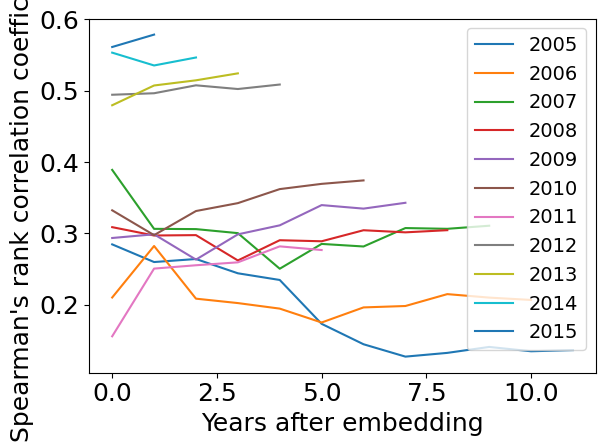

In [33]:
plt.plot(range(len(sp_2005)), sp_2005, label="2005")
plt.plot(range(len(sp_2006)), sp_2006, label="2006")
plt.plot(range(len(sp_2007)), sp_2007, label="2007")
plt.plot(range(len(sp_2008)), sp_2008, label="2008")
plt.plot(range(len(sp_2009)), sp_2009, label="2009")
plt.plot(range(len(sp_2010)), sp_2010, label="2010")
plt.plot(range(len(sp_2011)), sp_2011, label="2011")
plt.plot(range(len(sp_2012)), sp_2012, label="2012")
plt.plot(range(len(sp_2013)), sp_2013, label="2013")
plt.plot(range(len(sp_2014)), sp_2014, label="2014")
plt.plot(range(len(sp_2015)), sp_2015, label="2015")

#plt.plot(range(len(rand_avg)), rand_avg, "r--", label="Random selection")

plt.xlabel("Years after embedding")
plt.ylabel("Spearman's rank correlation coefficient")

plt.legend(fontsize=14)

plt.tight_layout()
#plt.savefig("../../../files/cutoff_co2-ch4_3by3bin.png")

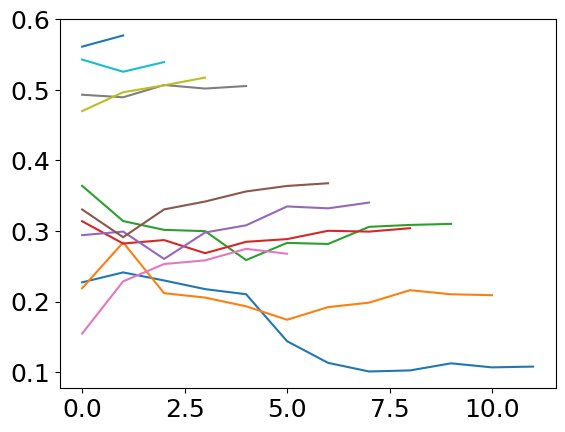

In [184]:
plt.plot(sp_2005)
plt.plot(sp_2006)
plt.plot(sp_2007)
plt.plot(sp_2008)
plt.plot(sp_2009)
plt.plot(sp_2010)
plt.plot(sp_2011)
plt.plot(sp_2012)
plt.plot(sp_2013)
plt.plot(sp_2014)
plt.plot(sp_2015)

In [134]:
sp_2015

[0.5613650918685287, 0.5787551676563181]

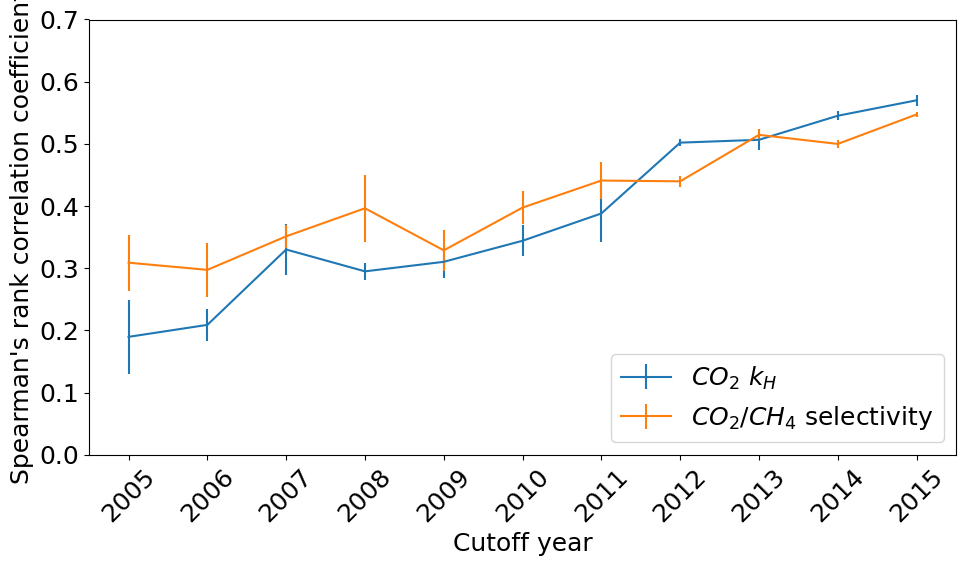

In [133]:
plt.figure(figsize=(10, 6))
years = [2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015]
sp_mean = [
    np.mean(sp_2005),
    np.mean(sp_2006),
    np.mean(sp_2007_new),
    np.mean(sp_2008),
    np.mean(sp_2009),
    np.mean(sp_2010),
    np.mean(sp_2011),
    np.mean(sp_2012),
    np.mean(sp_2013),
    np.mean(sp_2014),
    np.mean(sp_2015)
]
sp_std = [
    np.std(sp_2005),
    np.std(sp_2006),
    np.std(sp_2007_new),
    np.std(sp_2008),
    np.std(sp_2009),
    np.std(sp_2010),
    np.std(sp_2011),
    np.std(sp_2012),
    np.std(sp_2013),
    np.std(sp_2014),
    np.std(sp_2015)
]

sp_sel_mean = [
    np.mean(sp_2005_sel),
    np.mean(sp_2006_sel),
    np.mean(sp_2007_sel),
    np.mean(sp_2008_sel),
    np.mean(sp_2009_sel),
    np.mean(sp_2010_sel),
    np.mean(sp_2011_sel),
    np.mean(sp_2012_sel),
    np.mean(sp_2013_sel),
    np.mean(sp_2014_sel),
    np.mean(sp_2015_sel)
]
sp_sel_std = [
    np.std(sp_2005_sel),
    np.std(sp_2006_sel),
    np.std(sp_2007_sel),
    np.std(sp_2008_sel),
    np.std(sp_2009_sel),
    np.std(sp_2010_sel),
    np.std(sp_2011_sel),
    np.std(sp_2012_sel),
    np.std(sp_2013_sel),
    np.std(sp_2014_sel),
    np.std(sp_2015_sel)
]

plt.errorbar(years, sp_mean, sp_std, label="$CO_2\ k_H$")
plt.errorbar(years, sp_sel_mean, sp_sel_std, label="$CO_2/CH_4$ selectivity")

plt.xticks(years, labels=years, rotation=45)

plt.ylim([0, 0.7])
plt.xlabel("Cutoff year")
plt.ylabel("Spearman's rank correlation coefficient",)
plt.legend(loc='lower right')

plt.tight_layout()

plt.savefig("../../../files/final_v/2-spearman.png", dpi=1200)

# Project to the reference vector

In [83]:
# cutoff 2015
model_path = "../experiments/workflow/wandb/offline-run-20230619_162921-a03ypg0w/tmp/embedding_model.pt"
model, co2_kh_vecs, ch4_kh_vecs = load_pretrained(model_path)

bench_vecs = [co2_kh_vecs[-1], co2_kh_vecs[-2], co2_kh_vecs[-3]]

percent_2015 = []

test_years = [2016, 2017]
test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
test_corpus =  get_test_data(test_cif_dir, model)
test_cosines = get_similarities(test_corpus, bench_vecs)

model_acc, rand_acc = select_top_n(test_cosines, test_years, topP)
percent_2015.append((model_acc, rand_acc))

100%|██████████| 320/320 [00:01<00:00, 261.83it/s]


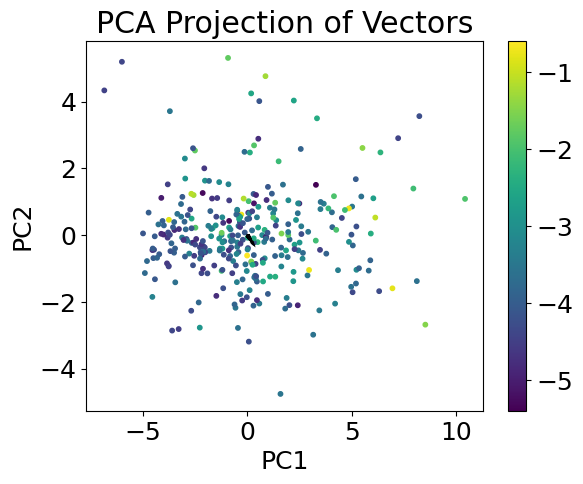

In [120]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assuming you have a list of vectors stored in 'vectors'
vectors = [arr for n, arr in test_corpus.items()]

# Convert the list of vectors into a 2D numpy array
X = np.array(vectors)

# Choose a reference vector
reference_vector = np.array(co2_kh_vecs[-1] + co2_kh_vecs[-2] + co2_kh_vecs[-3])

# Normalize the reference vector (optional, but recommended)
reference_vector = reference_vector / np.linalg.norm(reference_vector)

# Compute the dot product between the reference vector and each vector in X
projections = np.dot(X, reference_vector)

# Perform PCA to reduce the dimensionality to 2
pca = PCA(n_components=2)
X_2d = pca.fit_transform(X)

# Plot the projected vectors in 2D
plt.scatter(X_2d[:, 0], X_2d[:, 1], s=10, c=co2_values)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection of Vectors')
plt.colorbar()

# Plot the scaled vectors with respect to the reference vector

scaled_vectors = np.outer(projections, reference_vector)
plt.quiver(np.zeros_like(projections), np.zeros_like(projections),
           scaled_vectors[:, 0], scaled_vectors[:, 1], angles='xy',
           scale_units='xy', scale=1)

plt.show()


In [96]:
df = df.set_index("info.name")

In [98]:
co2_values = [df.loc[n, "outputs.logKH_CO2"] for n, arr in test_corpus.items()]

In [126]:
simi = [si[0] for n, si in test_cosines.items()]

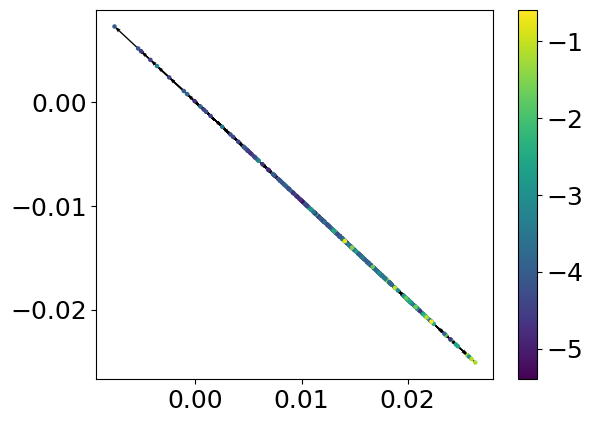

In [127]:

scaled_vectors = np.outer(simi, reference_vector)
plt.quiver(np.zeros_like(projections), np.zeros_like(projections),
           scaled_vectors[:, 0], scaled_vectors[:, 1], angles='xy',
           scale_units='xy', scale=1)
plt.scatter(scaled_vectors[:, 0], scaled_vectors[:, 1], c=co2_values, s=5)
plt.colorbar()

In [118]:
np.dot([2,3], np.array([1,1]).T)

5

# KPIs with different units

In [138]:
def load_pretrained(model_path):
    model = Doc2Vec.load(model_path)
    kpi_vectors = {}
    for key in model.dv.index_to_key:
        if "outputs" in key:
            kpi_vectors.update(
                {key: model.dv[key]}
            )
    return model, kpi_vectors

In [ ]:
def select_top_n(test_similarities, test_years, top_percent):
    topn = int(len(test_similarities)*top_percent)
    # recommendation from similarity
    similarities = np.array([np.array(sim).mean() for _, sim in test_similarities.items()])
    top_indices = similarities.argsort()[-topn:][::-1]
    recommendations = []
    for index in top_indices:
        recommendations.append((list(test_similarities)[index], similarities[index]))

    # topN from simulation
    names = df[df["info.year"].isin(test_years)]["info.name"].values
    simulations = df[df["info.year"].isin(test_years)][recom_target].values
    #simu_co2 = df[df["info.year"].isin(test_years)]["outputs.logKH_CO2"].values
    #simu_ch4 = df[df["info.year"].isin(test_years)]["outputs.logKH_CH4"].values
    #simulations = simu_co2 - simu_ch4
    top_simulation = simulations.argsort()[-topn:][::-1]
    true_top = []
    top_names = []
    for index in top_simulation:
        true_top.append((names[index], simulations[index]))
        top_names.append(names[index])
    
    # random selection 
    rand_acc_time = []
    time = 0
    while time < 5:
        random_names = random.choices(names, k=topn)
        true_or_false = [True if name in top_names else False for name in random_names]
        rand_acc_time.append(sum(true_or_false)/len(true_or_false))
        time += 1

    true_or_false = [True if name in top_names else False for name, sim in recommendations]
    recm_acc = sum(true_or_false)/len(true_or_false)

    rand_acc = np.mean(rand_acc_time)

    return recm_acc, rand_acc


In [153]:
# cutoff 2015
model_path = "../experiments/workflow/wandb/offline-run-20230612_155540-h3cqbnk8/tmp/embedding_model.pt"
model, kpi_vecs = load_pretrained(model_path)

bench_vecs = [
    kpi_vecs["outputs.pure_uptake_CO2_298.00_15000_9"] - kpi_vecs["outputs.logKH_CH4_9"] + kpi_vecs["outputs.logKH_CO2_9"],
    #kpi_vecs["outputs.pure_uptake_CO2_298.00_15000_9"] + kpi_vecs["outputs.logKH_CH4_0"] + kpi_vecs["outputs.logKH_CO2_8"],
    #kpi_vecs["outputs.pure_uptake_CO2_298.00_15000_9"] + kpi_vecs["outputs.logKH_CH4_0"] + kpi_vecs["outputs.logKH_CO2_7"],
    #kpi_vecs["outputs.pure_uptake_CO2_298.00_15000_8"] - kpi_vecs["outputs.logKH_CH4_9"] + kpi_vecs["outputs.logKH_CO2_9"],
    #kpi_vecs["outputs.pure_uptake_CO2_298.00_15000_7"] - kpi_vecs["outputs.logKH_CH4_9"] + kpi_vecs["outputs.logKH_CO2_9"],
    #kpi_vecs["outputs.pure_uptake_CO2_298.00_15000_9"],
    #kpi_vecs["outputs.pure_uptake_CO2_298.00_15000_8"],
    #kpi_vecs["outputs.logKH_CH4_0"],
    #kpi_vecs["outputs.logKH_CO2_9"],
    #kpi_vecs["outputs.logKH_CO2_8"],
    #kpi_vecs["outputs.logKH_CO2_9"] + kpi_vecs["outputs.logKH_CO2_8"], 
    #kpi_vecs["outputs.logKH_CH4_0"] + kpi_vecs["outputs.logKH_CH4_1"],
    #kpi_vecs["outputs.pure_uptake_CO2_298.00_15000_9"] + kpi_vecs["outputs.pure_uptake_CO2_298.00_15000_8"],
]

test_years = [2016, 2017]
test_cif_dir = ["../data/cifs/md_%s" %year for year in test_years]
test_corpus = get_test_data(test_cif_dir, model)

print(len(test_corpus))

test_cosines = get_similarities(test_corpus, bench_vecs)


100%|██████████| 320/320 [00:01<00:00, 207.03it/s]


320


In [154]:
test_cosines_mean = {cif: np.mean(cosines) for cif, cosines in test_cosines.items()}

In [155]:
sim_sort = sorted(test_cosines_mean.items(), key=lambda item: item[1], reverse=True)

In [156]:
test_cif = [cif for cif, _ in test_corpus.items()]
df_test = df.loc[test_cif]

In [157]:
import scipy.stats as ss

df_test["co2_rank"] = len(df_test["outputs.logKH_CO2"]) - ss.rankdata(df_test["outputs.logKH_CO2"])
df_test["ch4_rank"] = ss.rankdata(df_test['outputs.logKH_CH4'])
df_test["uptake_rank"] = len(df_test['outputs.pure_uptake_CO2_298.00_15000']) - ss.rankdata(df_test['outputs.pure_uptake_CO2_298.00_15000'])

sim_rank = [(sim[0], i+1) for i, sim in enumerate(sim_sort)]

In [158]:
num_kpis = 4
kpi_names = [
    "co2_rank",
    "ch4_rank",
    "uptake_rank"
]

list_programming = [
    {
        'Name': [cif for _ in range(num_kpis)],
        'X': range(num_kpis),
        'Rank': [df_test.loc[cif, kpi] for kpi in kpi_names] + [val]
    }
    for cif, val in sim_rank
]

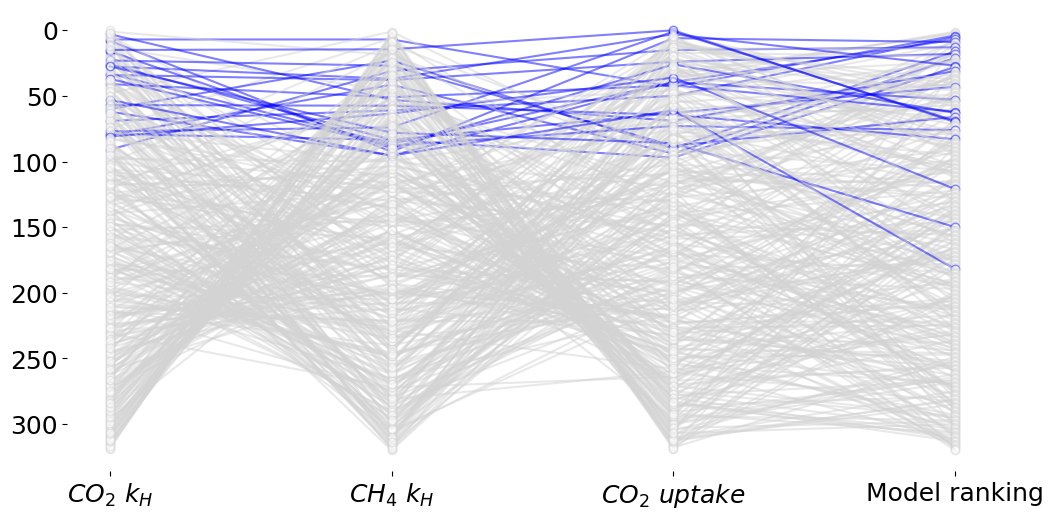

In [170]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (12,6)

for element in list_programming:
  if all(r < 100 for r in element["Rank"][:3]):
     color = "blue"
  else:
     color = "lightgrey"
  ax.plot(element["X"], 
          element["Rank"], 
          "o-",                      # format of marker / format of line
          color=color,
          markerfacecolor="white",
          alpha=0.5)
  
plt.xticks([0,1,2,3], labels=["$CO_2\ k_H$", "$CH_4\ k_H$", "$CO_2\ uptake$", "Model ranking"])
  
plt.gca().invert_yaxis()

for spine in ax.spines.values():
    spine.set_visible(False)

#plt.savefig("../../../files/final_v/3-ranking.png", dpi=1200)

In [128]:
kpis = [
    "outputs.logKH_CO2",
    "outputs.logKH_CH4",
    "outputs.pure_uptake_CO2_298.00_15000"
]

In [11]:
kpi_names = [key for key in model.dv.index_to_key if ("outputs" in key) | ("info" in key)]
kpi_vectors = np.array([model.dv[kpi] for kpi in kpi_names])

In [12]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=3, early_exaggeration=4, random_state=2230, n_jobs=-1)
kpi_2d = tsne.fit_transform(kpi_vectors)

In [13]:
from adjustText import adjust_text
from matplotlib.pyplot import plt

ImportError: cannot import name 'plt' from 'matplotlib.pyplot' (/Users/xiaoqi/opt/miniconda3/envs/mofgraph2vec/lib/python3.8/site-packages/matplotlib/pyplot.py)

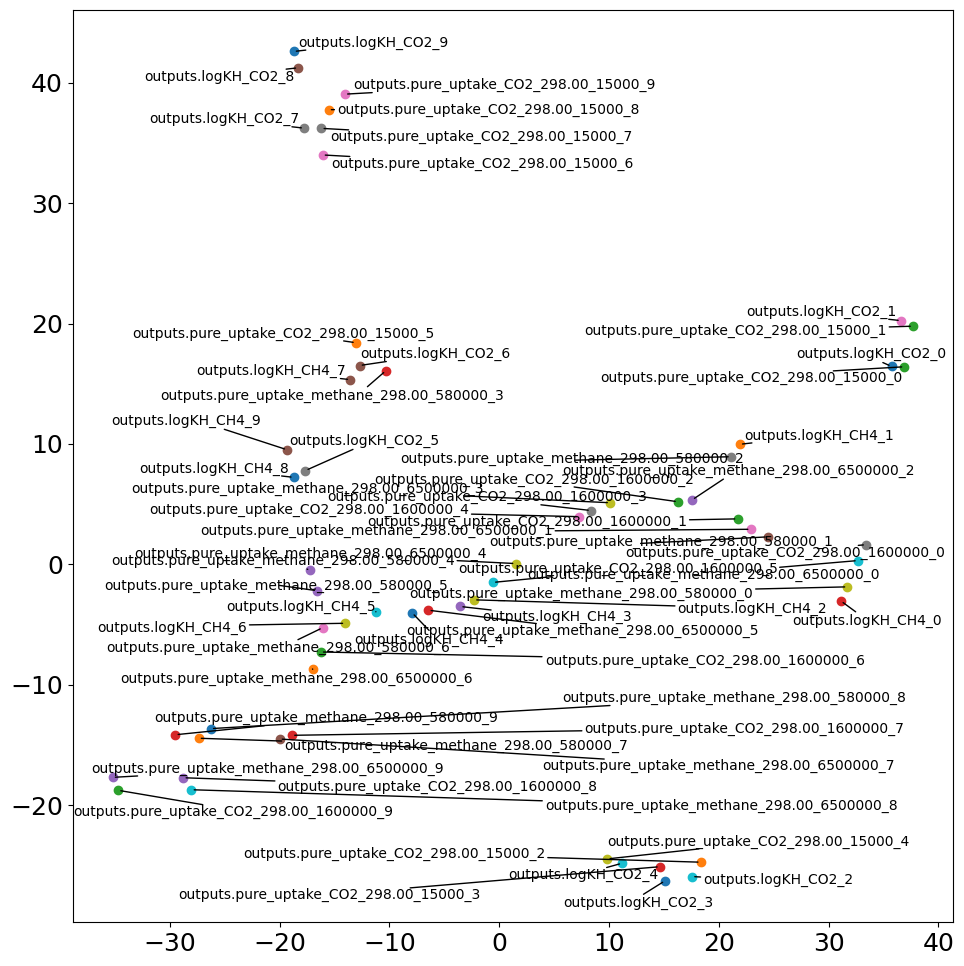

In [14]:
plt.figure(figsize=(10, 10))

texts = []
for i, kpi in enumerate(kpi_names):
    plt.scatter(kpi_2d[i,0], kpi_2d[i,1]) #, marker=markers[i], c=colors[i])
    texts.append(plt.annotate(kpi, (kpi_2d[:,0][i], kpi_2d[:,1][i]), fontsize=10))

#plt.legend(handles=[high_mk, medium_mk, low_mk])
adjust_text(texts, arrowprops=dict(arrowstyle='-'))
plt.tight_layout()
#plt.savefig("../../../files/final_v/5-tsne.png", dpi=1200)